This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
%run 0_parameters.ipynb


This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 1.0, 'contrast': 1.0, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.1, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-27', 'seed': 2019, 'N_cv': 8, 'do_compute': True}
Overwriting train.py
2019-03-28T11:48:11+01:00

CPython 3.7.2
IPython 7.4.0

numpy 1.16.2
matplotlib 3.0.3
torch 1.0.1.post2

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darw

In [2]:
figname = '../paper/fig_params'

In [3]:
%%writefile params.py
import os
import torch
from main import init, MetaML
from where import Where as ML
from what import WhatNet
        
import sys
opts = dict(filename='../data/2019-03-27', verbose=0, log_interval=0, do_compute=False  if len(sys.argv) > 1 else True)
#opts = dict(filename='debug', verbose=0, log_interval=0)

print(50*'-')
print(' parameter scan')
print(50*'-')

if True:
    args = init(**opts)
    #args.filename = '../data/2019-03-27'
    filename_train = args.filename + '_train.pt'
    if not(os.path.isfile(filename_train + '_lock')):
        open(filename_train + '_lock', 'w').close()
        print(50*'-')
        print('Default parameters')
        print(50*'-')
        from where import Where as ML
        from what import WhatNet
        ml = ML(args)
        ml.train(path=filename_train)
        # ml.main(path=args.filename)
        os.remove(filename_train + '_lock')

if True:
    args = init(**opts)
    mml = MetaML(args)
    if torch.cuda.is_available():
        mml.scan('no_cuda', [True, False])

    args = init(**opts)
    mml = MetaML(args)
    mml.scan('bias_deconv', [True, False])

results = {}
    
def update_results(results, parameter, accuracies, ci=0.005):
    from scipy.stats import beta

    if not parameter in results.keys(): results[parameter] = dict(value=[], accuracy=[], p_low=[], p_sup=[])
    for value in accuracies.keys():
        results[parameter]['value'].append(value)
        results[parameter]['accuracy'].append(accuracies[value][:-1].mean()*100)
        try:
            a1, b1, loc1, scale1 = beta.fit(accuracies[value][:-1], floc=0, fscale=1)
            p_low, p_sup = beta.ppf([ci, 1-ci], a=a1, b=b1)
            print(p_low, p_sup)
            
            results[parameter]['p_low'].append(p_low*100)
            results[parameter]['p_sup'].append(p_sup*100)
        except:
            results[parameter]['p_low'].append(accuracies[value][:-1].mean()*100)
            results[parameter]['p_sup'].append(accuracies[value][:-1].mean()*100)
        
    return results
            
for base in [2] if not args.filename == '../data/debug' else [2]:
    print(50*'-')
    print(' base=', base)
    print(50*'-')

    print(50*'-')
    print(' parameter scan : data')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args, base=base)
    for parameter in ['sf_0', 'B_sf', 'offset_std' , 'noise']: #, 'contrast'
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        
    print(50*'-')
    print(' parameter scan : network')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['dim1',
                      'bn1_bn_momentum',
                      'dim2',
                      'bn2_bn_momentum',
                      'p_dropout']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(' parameter scan : learning ')
    args = init(**opts)
    mml = MetaML(args, base=base)
    print(50*'-')
    print('Using SGD')
    print(50*'-')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        mml.parameter_scan(parameter)
    print(50*'-')
    print('Using ADAM')
    print(50*'-')
    args = init(**opts)
    args.do_adam = True
    mml = MetaML(args, tag='adam')
    for parameter in ['lr', 'momentum', 'minibatch_size', 'epochs']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)

    print(50*'-')
    print(' parameter scan : retina')
    print(50*'-')
    args = init(**opts)
    mml = MetaML(args)
    for parameter in ['N_theta',
                      'N_azimuth',
                      'N_eccentricity',
                      'rho']:
        accuracies = mml.parameter_scan(parameter)
        results = update_results(results, parameter, accuracies)
        

Overwriting params.py


In [4]:
%run params.py scan

--------------------------------------------------
 parameter scan
--------------------------------------------------
--------------------------------------------------
Default parameters
--------------------------------------------------
Loading accuracy... min, max= 0.0145 0.9852
Loading file ../data/2019-03-27_train.pt
scanning over bias_deconv = [True, False]
For parameter bias_deconv = True ,  Accuracy=72.7% +/- 0.3%  in 13946.4 seconds
For parameter bias_deconv = False ,  Accuracy=73.2% +/- 0.0%  in 11114.9 seconds
--------------------------------------------------
 base= 2
--------------------------------------------------
--------------------------------------------------
 parameter scan : data
--------------------------------------------------
scanning over sf_0 = [0.1        0.11892071 0.14142136 0.16817928 0.2        0.23784142
 0.28284271 0.33635857 0.4       ]
For parameter sf_0 = 0.100 ,  Accuracy=66.6% +/- 0.3%  in 12092.7 seconds
For parameter sf_0 = 0.119 ,  Accuracy=6

/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:603: RuntimeWarning: divide by zero encountered in double_scalars
  fac = xbar * (1 - xbar) / data.var(ddof=0) - 1
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:452: RuntimeWarning: invalid value encountered in double_scalars
  func = [s1 - n * (-psiab + sc.psi(a)),
/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:453: RuntimeWarning: invalid value encountered in double_scalars
  s2 - n * (-psiab + sc.psi(b))]


Accuracy=71.9% +/- 0.0%  in 8617.6 seconds
For parameter dim2 = 1414 ,  Accuracy=72.4% +/- 0.0%  in 9437.8 seconds
For parameter dim2 = 1681 ,  Accuracy=73.3% +/- 0.0%  in 10079.4 seconds
For parameter dim2 = 2000 ,  Accuracy=72.6% +/- 0.0%  in 10809.0 seconds
For parameter dim2 = 2378 ,  Accuracy=73.7% +/- 0.0%  in 12118.0 seconds
For parameter dim2 = 2828 ,  Accuracy=74.0% +/- 0.0%  in 13491.6 seconds
For parameter dim2 = 3363 ,  Accuracy=74.5% +/- 0.0%  in 14120.7 seconds
For parameter dim2 = 4000 ,  Accuracy=73.6% +/- 0.0%  in 15301.6 seconds
scanning over bn2_bn_momentum = [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
For parameter bn2_bn_momentum = 0.000 ,  Accuracy=74.2% +/- 0.0%  in 8841.3 seconds
For parameter bn2_bn_momentum = 0.125 ,  Accuracy=72.7% +/- 0.0%  in 10749.9 seconds
For parameter bn2_bn_momentum = 0.250 ,  Accuracy=72.7% +/- 0.0%  in 10813.6 seconds
For parameter bn2_bn_momentum = 0.375 ,  Accuracy=72.6% +/- 0.0%  in 10747.3 seconds
For parameter bn2_bn

In [5]:
print(accuracies)

{1.1856639455077373: array([6.56400000e-01, 6.58200000e-01, 6.58200000e-01, 6.58200000e-01,
       6.58200000e-01, 6.58200000e-01, 6.58200000e-01, 6.58200000e-01,
       1.74520218e+04]), 1.41: array([7.26200000e-01, 7.26200000e-01, 7.26200000e-01, 7.26200000e-01,
       7.26200000e-01, 7.26200000e-01, 7.26200000e-01, 7.26200000e-01,
       1.26797069e+04]), 1.6767820321538365: array([1.38000000e-01, 1.38400000e-01, 1.38400000e-01, 1.38400000e-01,
       1.38400000e-01, 1.38400000e-01, 1.38400000e-01, 1.38400000e-01,
       1.33523757e+04]), 1.994041122946064: array([1.24800000e-01, 1.30400000e-01, 1.30400000e-01, 1.30400000e-01,
       1.30400000e-01, 1.30400000e-01, 1.30400000e-01, 1.30400000e-01,
       1.35419781e+04]), 2.3713278910154747: array([1.26000000e-01, 1.30600000e-01, 1.30600000e-01, 1.30600000e-01,
       1.30600000e-01, 1.30600000e-01, 1.30600000e-01, 1.30600000e-01,
       1.35743797e+04]), 2.82: array([1.28600000e-01, 1.33200000e-01, 1.33200000e-01, 1.33200000e-01,
  

In [6]:
print(accuracies[list(accuracies.keys())[0]])

[6.56400000e-01 6.58200000e-01 6.58200000e-01 6.58200000e-01
 6.58200000e-01 6.58200000e-01 6.58200000e-01 6.58200000e-01
 1.74520218e+04]


In [7]:
data = accuracies[list(accuracies.keys())[0]][:-1]
print(data)

[0.6564 0.6582 0.6582 0.6582 0.6582 0.6582 0.6582 0.6582]


In [8]:

from scipy.stats import beta
beta.fit(data)

/usr/local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)


(2.716218311859877e-10,
 4.0743260411275294e-11,
 0.6563999999998591,
 0.0018000000001408003)

In [9]:
a1, b1, loc1, scale1 = beta.fit(data, floc=0, fscale=1)
print(a1, b1, loc1, scale1)

418369.50952543947 217474.57265896935 0 1


From https://github.com/laurentperrinet/bayesianchangepoint/blob/master/bayesianchangepoint/bcp.py#L312

In [10]:
p_low, p_sup = beta.ppf([.05, .95], a=a1, b=b1)
p_low, p_sup

(0.6569961618105908, 0.6589532717859645)

In [11]:
from scipy.stats import beta
beta.fit(data)
a1, b1, loc1, scale1 = beta.fit(data, floc=0, fscale=1)
p_low, p_sup = beta.ppf([.05, .95], a=a1, b=b1)
p_low, p_sup

(0.6569961618105908, 0.6589532717859645)

In [12]:
results['sf_0']['value'],  results['sf_0']['accuracy']

([0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4],
 [66.62750000000001,
  67.2825,
  68.67750000000001,
  71.18749999999999,
  72.61999999999999,
  74.1175,
  75.1625,
  76.08250000000001,
  76.5725])

## parameter scan

---> sf_0


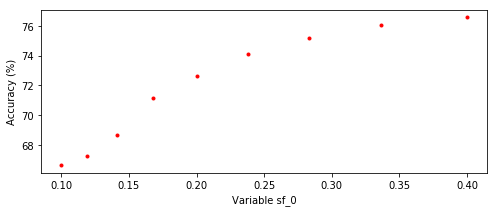

---> B_sf


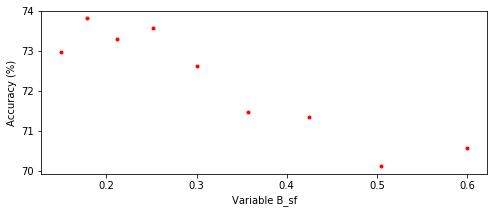

---> offset_std


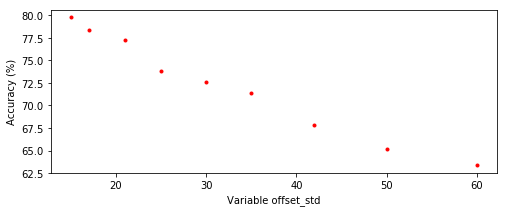

---> noise


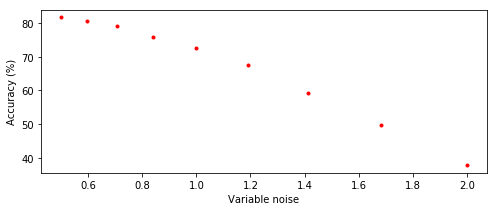

---> dim1


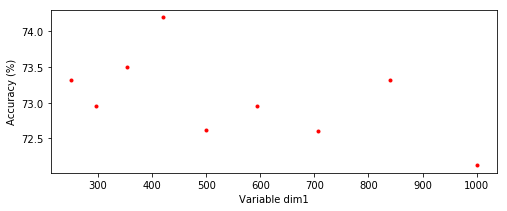

---> bn1_bn_momentum


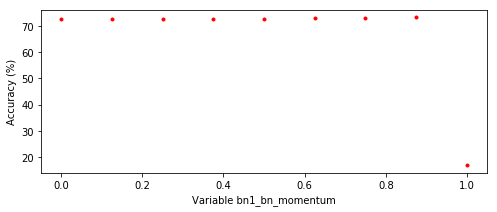

---> dim2


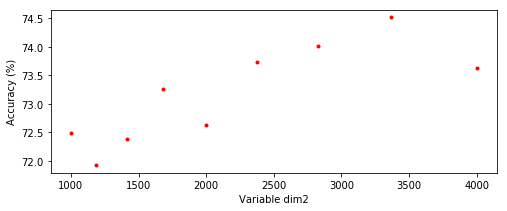

---> bn2_bn_momentum


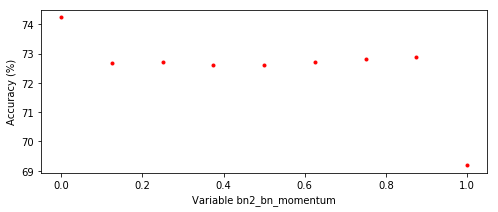

---> p_dropout


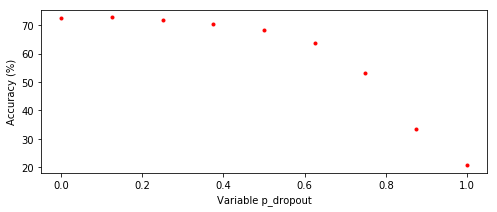

---> lr


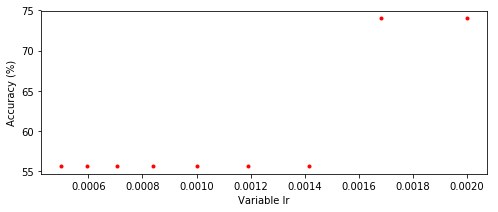

---> momentum


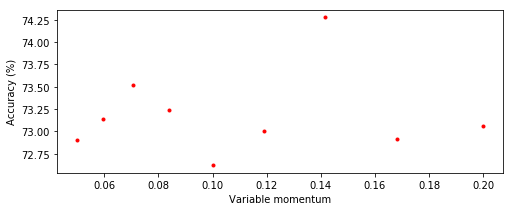

---> minibatch_size


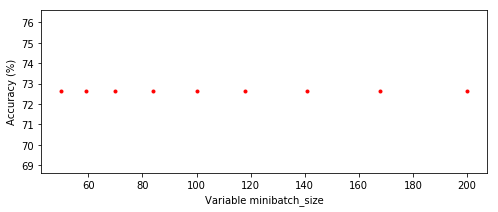

---> epochs


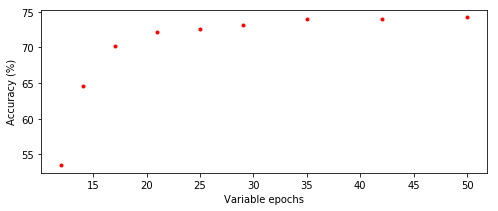

---> N_theta


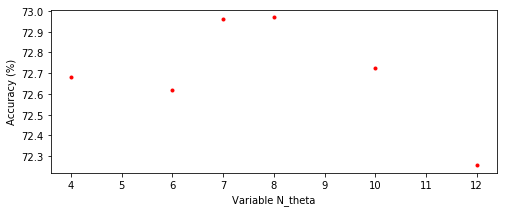

---> N_azimuth


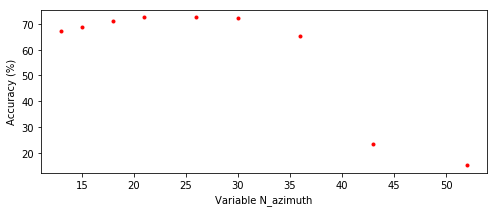

---> N_eccentricity


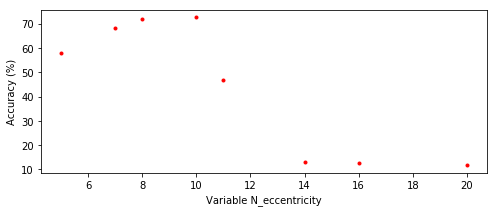

---> rho


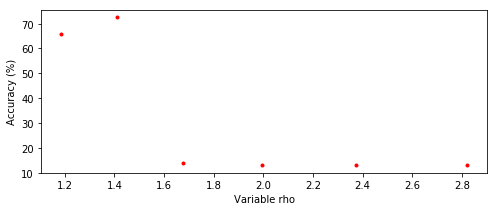

In [13]:
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(results[parameter]['value'], 
            results[parameter]['accuracy'], 'r.')
    plt.xlabel('Variable ' +  parameter)
    plt.ylabel('Accuracy (%)')

    plt.show()

In [14]:
results['sf_0']

{'value': [0.1,
  0.11892071150027211,
  0.14142135623730953,
  0.16817928305074292,
  0.2,
  0.23784142300054423,
  0.28284271247461906,
  0.33635856610148585,
  0.4],
 'accuracy': [66.62750000000001,
  67.2825,
  68.67750000000001,
  71.18749999999999,
  72.61999999999999,
  74.1175,
  75.1625,
  76.08250000000001,
  76.5725],
 'p_low': [65.9354347953428,
  67.05173371444766,
  68.66211153798774,
  70.26937037266737,
  72.61999999999999,
  74.10211297131013,
  75.0548051343286,
  75.60583105877005,
  75.66588732190476],
 'p_sup': [67.31567593241883,
  67.51281206002236,
  68.69288622706955,
  72.09630387480117,
  72.61999999999999,
  74.13288379372855,
  75.27002513100507,
  76.5556478736889,
  77.46601825405057]}

In [15]:
def plot_accuracy(result, xmin=50, fig=None, ax=None):
    if fig is None: fig, ax = plt.subplots(figsize=(5, 5))
    print(result['p_low'], result['p_sup'])
    ax.hlines(y=result['value'], xmin=result['p_low'], xmax=result['p_sup'], color='blue', alpha=.5, lw=7)
    ax.plot(result['accuracy'], result['value'], "o", color='blue')
    # print(value, accuracy)
    ax.hlines(y=result['value'], xmin=result['accuracy'], xmax=100, color='red')
    ax.hlines(y=result['value'], xmin=xmin, xmax=result['accuracy'], color='skyblue')

    plt.ylabel(parameter.capitalize())
    #print( results[parameter]['value'] )
    #print( np.min([np.float(k) for k in results[parameter]['value']]))
    #ax.vlines(100, np.min(results[parameter]['value']), np.max(results[parameter]['value']), 'k', label='max')
    plt.xlabel('Accuracy (%)')
    # Only draw spine between the y-ticks
    #ax.spines['left'].set_bounds(-1, 1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    return fig, ax

---> sf_0
[65.9354347953428, 67.05173371444766, 68.66211153798774, 70.26937037266737, 72.61999999999999, 74.10211297131013, 75.0548051343286, 75.60583105877005, 75.66588732190476] [67.31567593241883, 67.51281206002236, 68.69288622706955, 72.09630387480117, 72.61999999999999, 74.13288379372855, 75.27002513100507, 76.5556478736889, 77.46601825405057]


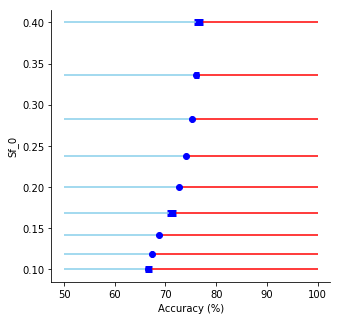

---> B_sf
[72.87268643900804, 73.45087921176268, 72.16099482677696, 73.36751558862322, 72.54255994834811, 71.03680908354787, 70.98899486471537, 69.13720887135891, 69.50689336641372] [73.05720580106596, 74.18730126403184, 74.42746917518677, 73.76695843935568, 72.72733444713734, 71.90105842959593, 71.72945094443371, 71.08791456417984, 71.61606564889054]


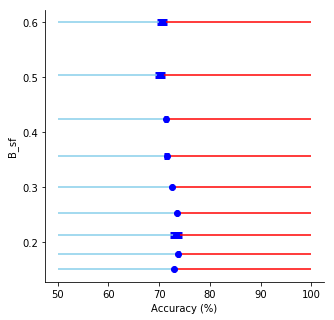

---> offset_std
[79.42669942624315, 77.85629746176208, 76.90240653566248, 73.70845555645845, 72.61999999999999, 70.81638703772164, 67.86, 64.73928261586028, 62.43396201485546] [80.10101902272683, 78.90867066865273, 77.51600934237015, 73.83149389472155, 72.61999999999999, 71.92014059164745, 67.86, 65.59936968141109, 64.25589100848576]


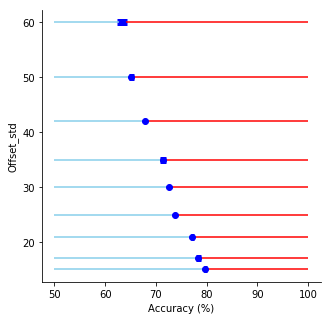

---> noise
[81.65750408575747, 80.36244818791673, 78.96555735799048, 75.56285003622403, 72.61999999999999, 66.94161793742896, 59.2325, 49.3995858060118, 37.28031094252188] [81.9968266222729, 80.97554056869507, 79.4284118131374, 76.45904212606776, 72.61999999999999, 68.269545173847, 59.2325, 49.83042244254118, 38.140745767326024]


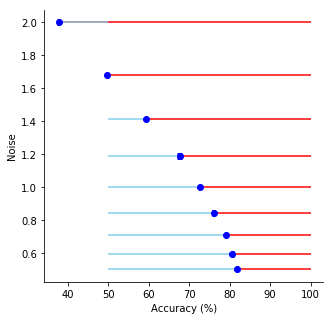

---> dim1
[73.32, 72.96, 73.49999999999999, 74.19999999999999, 72.61999999999999, 72.96000000000002, 72.60000000000001, 73.32000000000001, 72.12] [73.32, 72.96, 73.49999999999999, 74.19999999999999, 72.61999999999999, 72.96000000000002, 72.60000000000001, 73.32000000000001, 72.12]


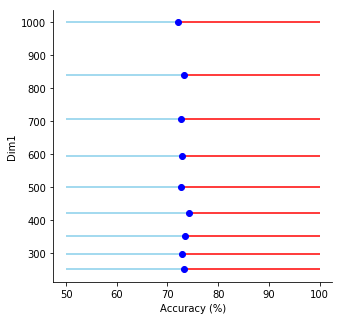

---> bn1_bn_momentum
[72.66, 72.61999999999999, 72.74, 72.61999999999999, 72.61999999999999, 72.85999999999999, 73.05999999999999, 73.25999999999999, 16.78] [72.66, 72.61999999999999, 72.74, 72.61999999999999, 72.61999999999999, 72.85999999999999, 73.05999999999999, 73.25999999999999, 16.78]


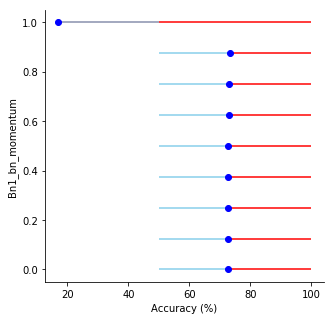

---> dim2
[72.47999999999999, 71.91999999999999, 72.38000000000001, 73.25999999999999, 72.61999999999999, 73.74000000000001, 74.02, 74.52, 73.62] [72.47999999999999, 71.91999999999999, 72.38000000000001, 73.25999999999999, 72.61999999999999, 73.74000000000001, 74.02, 74.52, 73.62]


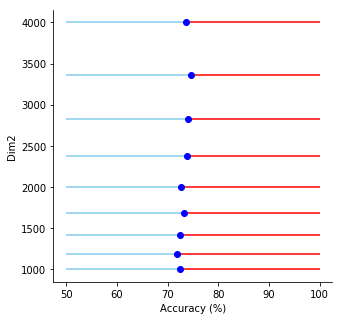

---> bn2_bn_momentum
[74.24, 72.67999999999999, 72.69999999999999, 72.62, 72.6, 72.7, 72.82000000000001, 72.88000000000001, 69.18] [74.24, 72.67999999999999, 72.69999999999999, 72.62, 72.6, 72.7, 72.82000000000001, 72.88000000000001, 69.18]


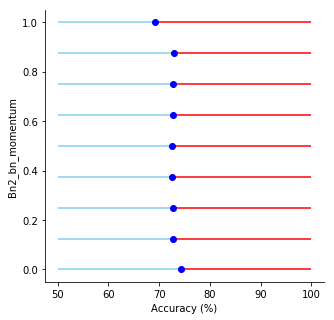

---> p_dropout
[72.61999999999999, 71.9181081238982, 70.81143291749554, 69.42558915629088, 67.48306987179888, 62.28649355594544, 51.32871119543289, 31.36649764174731, 20.54] [72.61999999999999, 73.71675564983522, 72.83654160683278, 71.39409172003622, 69.33894635221003, 65.4917148193497, 55.08631689645252, 35.2289813440693, 20.54]


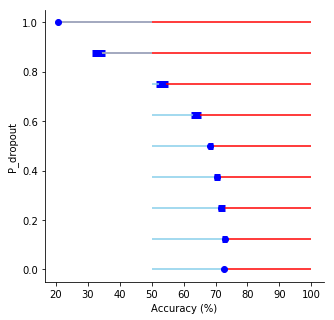

---> lr
[55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 74.04, 74.04] [55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 55.60000000000001, 74.04, 74.04]


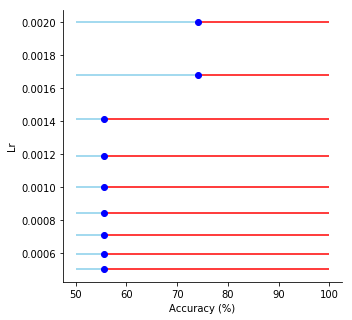

---> momentum
[72.9, 73.14, 73.52, 73.24, 72.61999999999999, 73.00000000000001, 74.28, 72.92, 73.06] [72.9, 73.14, 73.52, 73.24, 72.61999999999999, 73.00000000000001, 74.28, 72.92, 73.06]


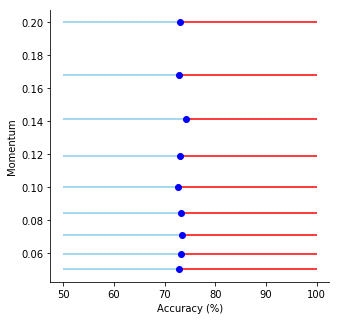

---> minibatch_size
[72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999] [72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999, 72.61999999999999]


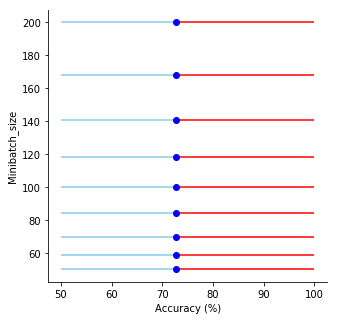

---> epochs
[53.42, 64.6, 70.25999999999999, 72.22, 72.61999999999999, 73.10000000000001, 73.94, 73.97999999999999, 74.26] [53.42, 64.6, 70.25999999999999, 72.22, 72.61999999999999, 73.10000000000001, 73.94, 73.97999999999999, 74.26]


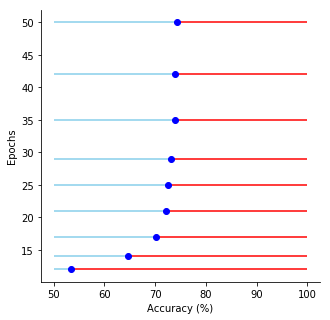

---> N_theta
[72.17117753639047, 72.61999999999999, 72.34496048275494, 72.9083979258607, 72.19806078322497, 72.0389606019174] [73.19060415978397, 72.61999999999999, 73.57027697778749, 73.03155408874129, 73.24851254064852, 72.47047826639835]


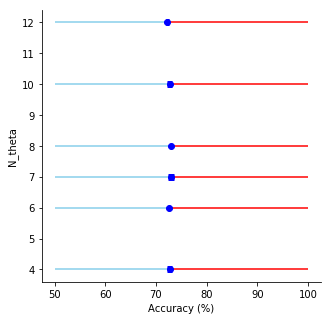

---> N_azimuth
[66.98869394029471, 68.29429159975896, 70.30102467190686, 71.8284603497664, 72.61999999999999, 71.92888247623563, 64.35507673606702, 21.383611707985477, 14.950545950154098] [67.6952339174677, 69.59167625251538, 71.7233830412021, 73.3889856060377, 72.61999999999999, 72.66946100417341, 66.59054907088186, 25.784517545923137, 15.104630706676625]


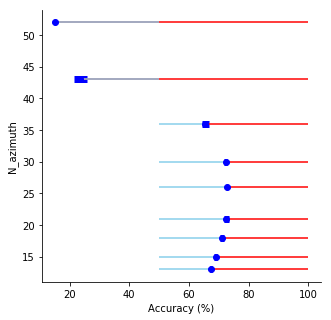

---> N_eccentricity
[57.61939918853892, 67.94259150162775, 71.75786710904343, 72.61999999999999, 45.16130896555476, 13.03748126855143, 12.728437121768692, 11.434230129333022] [58.05043909033524, 68.12733163120733, 72.09679419395, 72.61999999999999, 48.39717106163929, 13.283047172387608, 12.851700588769678, 11.832378652996612]


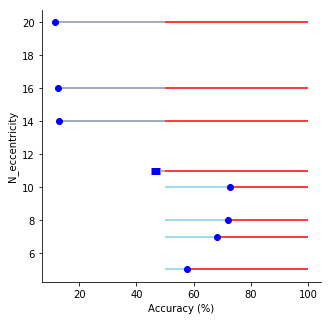

---> rho
[65.65902809451738, 72.61999999999999, 13.804222247227397, 12.538488820766075, 12.648145515318996, 12.908156133436833] [65.93582561317977, 72.61999999999999, 13.865809018396636, 13.408246486233576, 13.361370977029496, 13.62125224446702]


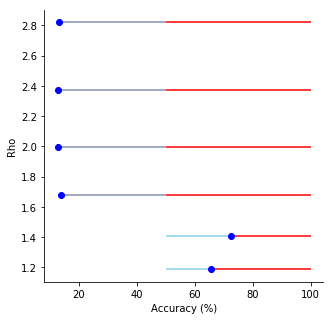

In [16]:
figname_ = 'accuracy_'
figname_ = ''

tex = ''
for parameter in results.keys():
    print('--->',  parameter)
    fig, ax = plot_accuracy(results[parameter])
    plt.show()
    if not figname_ == '':
        fig_dir = './'
        fig_ext = '.pdf'
        fname = figname_ + parameter + fig_ext
        tex += "\includegraphics[width=.0666\linewidth]{"+ fname + "} \n"
        fig.savefig(os.path.join(fig_dir, fname),
                bbox_inches='tight', pad_inches=0)
print(tex)

# summary


TypeError: plot_accuracy() got multiple values for argument 'xmin'

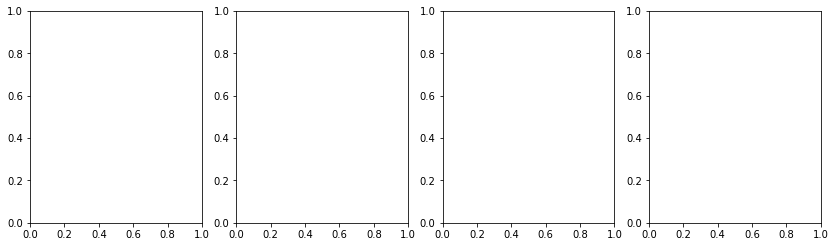

In [17]:
parameters = ['dim1', 'dim2', 'momentum', 'epochs'] # 'noise', 'lr', 
fig, axs = plt.subplots(1, len(parameters), figsize = (figwidth, figwidth/len(parameters)*1.1))

for ax, parameter in zip(axs, parameters):
    fig, ax = plot_accuracy(results[parameter], xmin=10, fig=fig, ax=ax)

fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.15)

In [ ]:
figname + '.pdf'

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*